loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz

0
nn 71
shift [0.], tilt [0.],  bias [0.], res [0.]
random seed
IRFModels

  Name                      : dataset_N-irf
  Datasets names            : dataset_N
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffAreaIRFModel
  PSF model type            : 
  Parameters:
    bias                  (frozen):      0.000                   
    resolution            (frozen):      0.000                   
    norm                          :      0.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    reference             (frozen):    100.000       TeV         


shift 1.0
fit w/o nui ended:
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 204
	total stat : 90455.20

CovarianceResult

	backe

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


shift 1.0


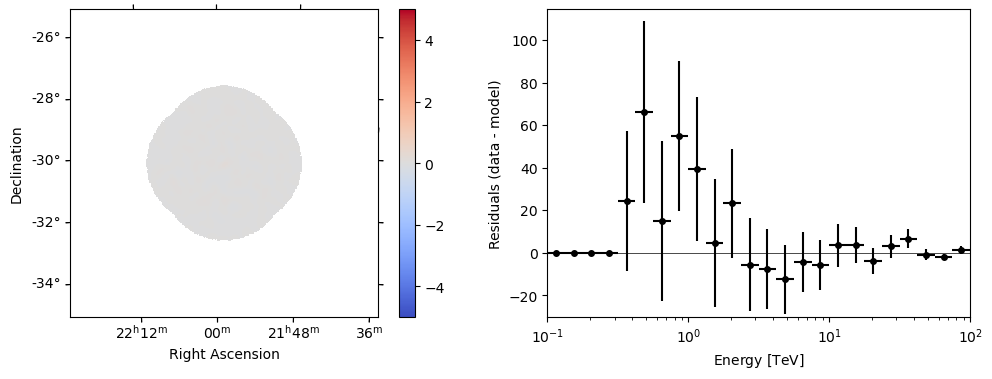

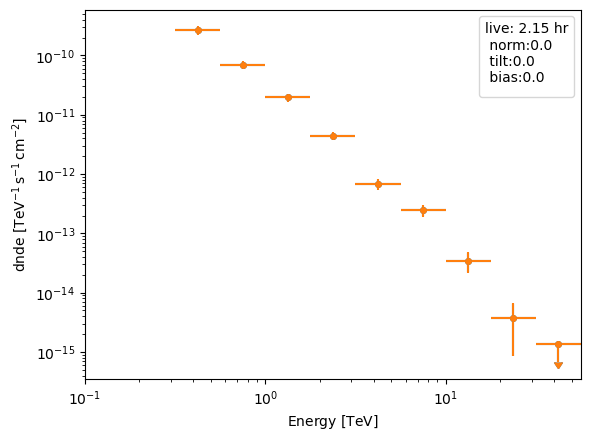

In [1]:
def save():
    with open(f"{path}/data/1_P_draw_info.txt", "a") as myfile:
        info = str(float(shift_rnd[0])) + '    '+ str(float(tilt_rnd[0])) + '    '
        info += str(float(bias_rnd[0])) + '    '+ str(float(res_rnd[0])) + '    '
        info +=  str(float(dataset.stat_sum())) + '\n'
        myfile.write(info)
    with open(f"{path}/data/1_P_draw_par.txt", "a") as myfile:
        myfile.write(stri + '\n')
    with open(f"{path}/data/1_P_draw_flux.txt", "a") as myfile:
        myfile.write( ff + '\n')
    with open(f"{path}/data/1_P_draw_flux2e.txt", "a") as myfile:
        myfile.write( ff2 + '\n')

    with open(f"{path}/data/1_N_P_draw_par.txt", "a") as myfile:
        myfile.write(stri_N + '\n')
    with open(f"{path}/data/1_N_P_draw_flux.txt", "a") as myfile:
        myfile.write( ffN + '\n')
    with open(f"{path}/data/1_N_P_draw_flux2e.txt", "a") as myfile:
        myfile.write( ffN2 + '\n')
        
def computing_contour(dataset, note):
        
    results = []
    for parname1, parname2 in parameter_names :
        numpoints = 5
        print( parname1, parname2, numpoints)
        result = fit_cor.stat_contour(dataset,
                             dataset.models.parameters[parname1],
                             dataset.models.parameters[parname2],
                              numpoints=numpoints 
                                      
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "success":
                contour_write[k] = result[k].tolist()
        import yaml
        with open(f"{path}/data/contours/{note}_{parname1}_{parname2}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)
        



import gammapy 
import pyximport
import numpy as np
import astropy.units as u
import sys
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
from gammapy.modeling.models import IRFModels, EffAreaIRFModel, ERecoIRFModel
    
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
import Dataset_load 
from  Dataset_Setup import Setup, GaussianCovariance_matrix


c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

livetimes = c['livetimes']
livetime = c['livetime']
sys = c['sys']
norm = c['norm'] 
tilt = c['tilt'] 
bias =  c['bias'] 
resolution = c['resolution'] 
path = f"../{c['folder']}"
parameter_names = c['parameter_names']        

#for live in livetimes[8:]:
for live in [livetime]:

    dataset_asimov = Dataset_load.create_asimov(
        model=c['model'], source=c['source'], parameters=None,
        livetime = f"{live}-hr"
    )

    mask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1)>0
    ebins = dataset_asimov.counts.geom.axes[0].center[mask]


    N = 1
    save_flux = True
    save_fluxpoints = 1
    save_fluxpoints_N = 1
    dataset_N = True
    contour = 0
    zero_sys = 1


    for n in range(N):
        print()
        print('====' * 30)
        print(n)
        print('====' * 30)
        res_rnd = np.random.normal(0, resolution, 1)
        bias_rnd =  np.random.normal(0, bias, 1)
        shift_rnd = np.random.normal(0, norm, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        if zero_sys:
            nn = 71#np.random.randint(0,100)
            print("nn", nn)
            rnd = nn
        else:
            rnd = "True"
        rnd = "False"
        
        if zero_sys:
            shift_rnd, tilt_rnd = np.array([0.]), np.array([0.])
            bias_rnd, res_rnd = np.array([0.]), np.array([0.])
        
        print(f"shift {shift_rnd}, tilt {tilt_rnd},  bias {bias_rnd}, res {res_rnd}")
        setup = Setup(dataset_input=dataset_asimov, rnd = rnd)
        setup.set_up_irf_sys(bias_rnd, res_rnd, shift_rnd, tilt_rnd)

        dataset, dataset_N = setup.run()
        # irf model
        # happens in set_up_irf_sys
        # setup.set_irf_model(dataset_N)
        if  "Eff_area" in sys:
            dataset_N.models.parameters['resolution'].frozen = True
            dataset_N.models.parameters['bias'].frozen = True
            dataset_N.irf_model.parameters['tilt'].frozen = False
            dataset_N.irf_model.parameters['norm'].frozen = False
            dataset_N.e_reco_n = 10
            setup.set_irf_prior(dataset_N, bias, resolution, norm, tilt)
            print(dataset_N.irf_model)
            
        if sys == "E_reco":
            dataset_N.models.parameters['resolution'].frozen = True
            dataset_N.models.parameters['bias'].frozen = False
            dataset_N.irf_model.parameters['tilt'].frozen = True
            dataset_N.irf_model.parameters['norm'].frozen = True
            setup.set_irf_prior(dataset_N, bias, resolution, norm, tilt)
        
        if  "Combined"  in sys:
            dataset_N.models.parameters['resolution'].frozen = True
            dataset_N.models.parameters['bias'].frozen = False
            dataset_N.irf_model.parameters['tilt'].frozen = False
            dataset_N.irf_model.parameters['norm'].frozen = False
            setup.set_irf_prior(dataset_N, bias, resolution, norm, tilt)
            
        if sys == "BKG":
            magnitude = c['magnitude']
            corrlength = c['corrlength']
            # piece wise model
            # remove old bkg model
            setup.set_up_bkg_sys_V( breake = 10,
                                index1 = 2,
                                index2 = 1.5, 
                                magnitude = magnitude )

            dataset_asimov, dataset_asimov_N = setup.run()

            setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
            setup.set_piecewise_bkg_model(dataset_asimov_N)
            # energy of the following parameters smaller than ethrshold
            dataset_asimov_N.background_model.parameters['norm0'].frozen = True
            dataset_asimov_N.background_model.parameters['norm1'].frozen = True
            dataset_asimov_N.background_model.parameters['norm2'].frozen = True
            dataset_asimov_N.background_model.parameters['norm3'].frozen = True
            setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
            frozen_pos = 1
            if frozen_pos:
                dataset_asimov.models.parameters['lon_0'].frozen = True
                dataset_asimov.models.parameters['lat_0'].frozen = True
                dataset_asimov_N.models.parameters['lon_0'].frozen = True
                dataset_asimov_N.models.parameters['lat_0'].frozen = True
        
        fit_cor = Fit(store_trace=False)
        dataset.plot_residuals()
        result_cor = fit_cor.run([dataset])
        print("fit w/o nui ended:")
        print(result_cor)
        print(dataset.models)

        stri = ""
        parameters =  ['amplitude', 'index', 'lambda_',]# 'norm', 'tilt']
        if "crab_break" in c['model']:
            parameters =  ['amplitude', 'index1', 'index2', 'ebreak', 'beta',]# 'norm', 'tilt']
        if "crab_log" in c['model']:
            parameters =  ['amplitude', 'alpha', 'beta',]# 'norm', 'tilt']
            
        for p in parameters:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        stri += str(live) + "  "
        print(stri)

        for p in ['norm', 'tilt']:
            stri += str(dataset.background_model.parameters[p].value)  + '   ' +  str(dataset.background_model.parameters[p].error)  + '   '
        stri += str(live) + "  "
        print(stri)
     
        energy_edges = dataset.geoms['geom'].axes[0].edges#[::2]
        energy_bounds = (energy_edges[0], energy_edges[-1] ) #* u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            len(energy_edges),
            node_type='center'
        )
        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff2 = str()
        for f in fluxe2:
            ff2 += str(f) + "  "

        fluxes = []
        for e in energy.center:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset_N])
        print()
        print("fit with nui ended:")
        print(result_cor)
        print(dataset_N.models)


        stri_N = ""
        for p in parameters:
            stri_N += str(dataset_N.models.parameters[p].value)  + '   ' +  str(dataset_N.models.parameters[p].error)  + '   '
        for p in ['norm', 'tilt']:
            stri_N += str(dataset_N.background_model.parameters[p].value)  + '   ' +  str(dataset_N.background_model.parameters[p].error)  + '   '
        parameters_  =  ['norm', 'tilt', 'bias', 'resolution']
        for p in parameters_:
            stri_N += str(dataset_N.irf_model.parameters[p].value)  + '   ' +  str(dataset_N.irf_model.parameters[p].error)  + '   '
        
        stri_N += str(live) + "  "
        print(stri_N)

        fluxes = []
        for e in energy.center:
            flux =  dataset_N.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ffN = str()
        for f in fluxes:
            ffN += str(f) + "  "

 
        fluxe2, _ = dataset_N.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ffN2 = str()
        for f in fluxe2:
            ffN2 += str(f) + "  "

        rnds = f"{shift_rnd[0]:.6}_{tilt_rnd[0]:.6}_{bias_rnd[0]:.6}_{res_rnd[0]:.6}"
        if save_fluxpoints:
            print("computing Fluxpoints")
            dataset.models.parameters['amplitude'].scan_n_sigma  = 5
            dataset_N.models.parameters['amplitude'].scan_n_sigma  = 5

            esti  = FluxPointsEstimator(energy_edges= energy_edges[::2][:-1], 
                                        selection_optional =  [ "ul"],
                                        norm_min=0.2,
                                    norm_max=200,
                                    norm_n_values=15,
                                       )
            fluxpoints = esti.run([dataset])
            import matplotlib.pyplot as plt
            fig = plt.figure()
            ax = fluxpoints.plot()
            
            # freeze all but IRF for fp and reopt = True
            dataset_N.models[0].parameters.freeze_all()
            dataset_N.models[0].parameters['amplitude'].frozen = False
            dataset_N.background_model.parameters.freeze_all()
            esti_  = FluxPointsEstimator(energy_edges= energy_edges[::2][:-1], selection_optional =[ "ul"],# "errn-errp", "all",
                                        norm_min=0.2,
                                    norm_max=200,
                                    norm_n_values=15,
                                       reoptimize=True)
            fluxpoints_N = esti_.run([dataset_N])
            fluxpoints_N.plot(ax = ax)
            ax.legend(title = f"live: {live:.3} hr\n norm:{shift_rnd[0]:.3}\n tilt:{tilt_rnd[0]:.3}\n bias:{bias_rnd[0]:.3}")
            fig.savefig(f"{path}/data/fluxpoints/plots/{live}_{rnds}_{nn}.png")
            
            fluxpoints_N.write(f'{path}/data/fluxpoints/1P_fluxpoints_N_{live}_{rnds}_{nn}.fits',
                              overwrite = True)
            dataset_N.models.write(f'{path}/data/fluxpoints/1P_model_N_{live}_{rnds}_{nn}.yaml',
                                  overwrite = True)
            fluxpoints.write(f'{path}/data/fluxpoints/1P_fluxpoints_{live}_{rnds}_{nn}.fits',
                            overwrite = True)
            dataset.models.write(f'{path}/data/fluxpoints/1P_model_{live}_{rnds}_{nn}.yaml',
                                overwrite = True)
            with open(f"{path}/data/fluxpoints/1P_draw_fluxpoints.txt", "a") as myfile:
                myfile.write(str(nn) + '\n')
        if contour:
            computing_contour(dataset, rnds)
            print("N")
            computing_contour(dataset_N, "N"+rnds)
            with open(f"{path}/data/contours/1_P_draw_info.txt", "a") as myfile:
                info = str(float(shift_rnd[0])) + '    '+ str(float(tilt_rnd[0])) + '    '
                info += str(float(bias_rnd[0])) + '    '+ str(float(res_rnd[0])) + '    '
                info +=  str(float(dataset.stat_sum())) + '\n'
                myfile.write(info)
            with open(f"{path}/data/contours/1_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')

            with open(f"{path}/data/contours/1_N_P_draw_par.txt", "a") as myfile:
                myfile.write(stri_N + '\n')

        if zero_sys == False and contour ==False: # else only the fluxpoints and models are saved but not the info
            save()


In [2]:
%matplotlib inline
plt.show()

shift 1.0


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

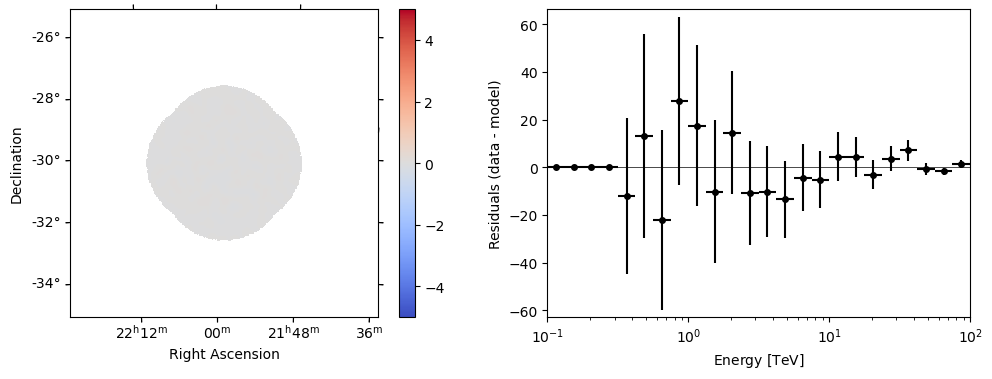

In [3]:
dataset.plot_residuals()

shift 1.0


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

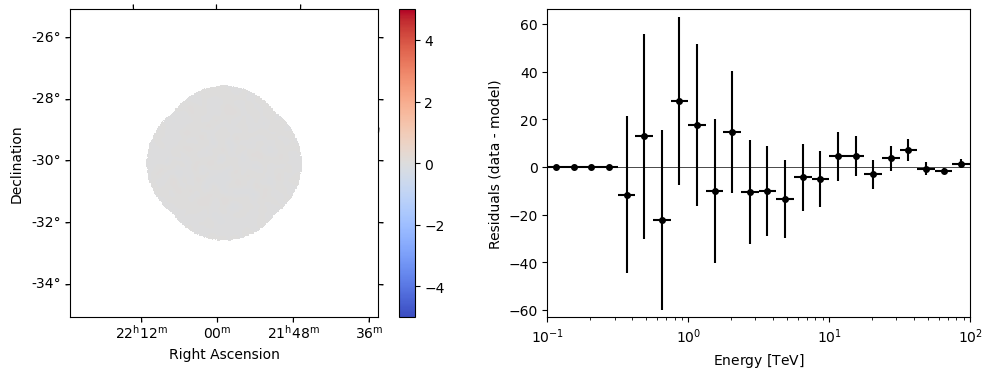

In [4]:
dataset_N.plot_residuals()

shift 1.0
shift 1.0


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]'>

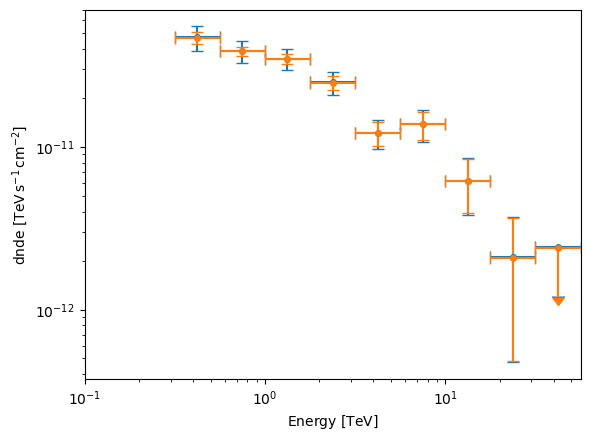

In [5]:
ax = fluxpoints_N.plot(energy_power = 2, capsize = 4, color = 'tab:blue')
fluxpoints.plot(ax = ax, energy_power = 2,  capsize = 4, color = 'tab:orange')


In [6]:
fluxpoints_N.sqrt_ts.data

array([[[        nan]],

       [[        nan]],

       [[23.92514949]],

       [[32.71305678]],

       [[32.54064169]],

       [[24.27183406]],

       [[13.45004758]],

       [[12.15599749]],

       [[ 6.61592227]],

       [[ 3.04575228]],

       [[-0.76661564]]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


shift 1.0
shift 1.0


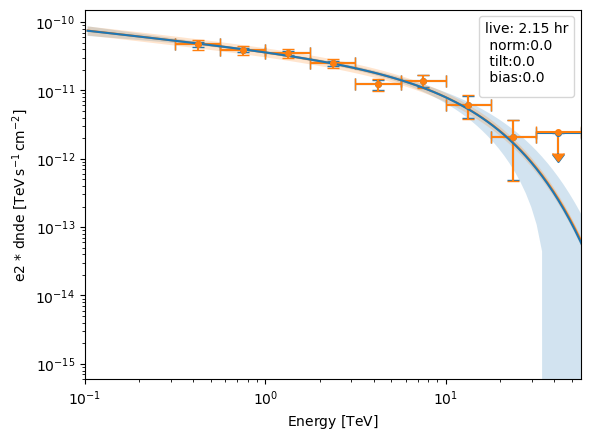

In [7]:
fig = plt.figure()
ax = fluxpoints.plot(energy_power = 2, capsize = 4, color = 'tab:blue')
fluxpoints_N.plot(ax = ax, energy_power = 2,  capsize = 4, color = 'tab:orange')
dataset_N.models[0].spectral_model.plot(energy_power = 2, color = 'tab:orange')
dataset.models[0].spectral_model.plot(energy_power = 2, color = 'tab:blue')
dataset.models[0].spectral_model.plot_error(energy_power = 2, ax = ax, facecolor = 'tab:blue')
dataset_N.models[0].spectral_model.plot_error(energy_power = 2, ax = ax, facecolor = 'tab:orange')

ax.legend(title = f"live: {live:.3} hr\n norm:{shift_rnd[0]:.3}\n tilt:{tilt_rnd[0]:.3}\n bias:{bias_rnd[0]:.3}")
#ax.set_ylim(5e-13, 0.8e-10)



In [8]:
fluxpoints

In [9]:
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.284   +/-    0.08             
    amplitude                     :   3.94e-11   +/- 2.4e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.095   +/-    0.03 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-bkg
  Datasets names            : ['dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1

In [10]:
print(dataset_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      2.287                   
    amplitude                     :   3.93e-11   +/- 6.0e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_               (frozen):      0.094       1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    329.680       deg         
    lat_0                 (frozen):    -30.222       deg         

Component 1: IRFModels

  Name                      : dataset_N-irf
  Datasets names            : dataset_N
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffAreaIRFModel
  PSF model type            : 
  Parameters:
    bias          